In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/q-quora/q_quora.csv


In [ ]:
# Load and preprocess the dataset
df = pd.read_csv("/kaggle/input/q-quora/q_quora.csv")



df = df[df['is_duplicate'].apply(lambda x: str(x).strip().isdigit())]


df.reset_index(drop=True, inplace=True)

# Convert 'is_duplicate' column to integer and create 'id' column
df.loc[:, 'is_duplicate'] = df['is_duplicate'].astype(int)
df.loc[:, "id"] = df.index
df.drop(['id','qid1','qid2','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
# Download and initialize necessary resources for text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# Ensure the 'is_duplicate' column contains only numeric types
df['is_duplicate'] = pd.to_numeric(df['is_duplicate'], errors='coerce')
df = df.dropna(subset=['is_duplicate'])
df['is_duplicate'] = df['is_duplicate'].astype(int)
df = df.dropna()
df

/tmp/ipykernel_122/1407710665.py:2: DtypeWarning: Columns (7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/q-quora/q_quora.csv")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...
404010,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404011,Do you believe there is life after death?,Is it true that there is life after death?,1
404012,What is one coin?,What's this coin?,0
404013,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import nltk
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

# Custom attention mechanism (self-attention layer with layer normalization and feedforward network)
class SelfAttention(torch.nn.Module):
    def __init__(self, embed_size, heads, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = torch.nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = torch.nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = torch.nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = torch.nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm1 = torch.nn.LayerNorm(embed_size)
        self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(embed_size, embed_size * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(embed_size * 4, embed_size)
        )
        self.layer_norm2 = torch.nn.LayerNorm(embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        attention = self.dropout(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        out = self.fc_out(out)

        # Add layer normalization and feedforward network
        out = self.layer_norm1(out + query)
        out = self.feedforward(out)
        out = self.layer_norm2(out + query)

        return out

# Preprocessing function (cleaning, tokenization)
def preprocess_data(df):
    # Example preprocessing steps
    df['question1'] = df['question1'].str.lower().str.replace('[^a-z0-9\s]', '', regex=True)
    df['question2'] = df['question2'].str.lower().str.replace('[^a-z0-9\s]', '', regex=True)
    return df

# Tokenization and encoding function
def tokenize_and_encode(texts, tokenizer, max_length=64):
    input_ids = []
    attention_masks = []

    for text in texts:
        question1, question2 = text.split('[SEP]')
        encoded_dict = tokenizer.encode_plus(
            question1,
            question2,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

# Load and preprocess data
df = preprocess_data(df)

# Define MiniLM model and tokenizer
model_name = 'microsoft/MiniLM-L12-H384-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Example texts and labels
texts = (df['question1'] + ' [SEP] ' + df['question2']).tolist()
labels = torch.tensor(df['is_duplicate'].values)

# Tokenize and encode data
input_ids, attention_masks = tokenize_and_encode(texts, tokenizer)

# Train-test split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=42, test_size=0.2)

# DataLoader for training and validation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store training and validation loss for each epoch
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
train_accuracies = []

# Training loop
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    val_preds = []
    val_true = []
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, model.num_labels), b_labels.view(-1))
            val_loss += loss.item()

            val_preds.extend(torch.argmax(logits, dim=1).flatten().tolist())
            val_true.extend(b_labels.flatten().tolist())

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(val_true, val_preds)
    precision = precision_score(val_true, val_preds)
    recall = recall_score(val_true, val_preds)
    f1 = f1_score(val_true, val_preds)

    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    # Training accuracy
    model.eval()
    train_preds = []
    train_true = []
    for batch in DataLoader(TensorDataset(train_inputs, train_masks, train_labels), batch_size=batch_size):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            train_preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
            train_true.extend(b_labels.cpu().tolist())

    train_accuracy = accuracy_score(train_true, train_preds)
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break




[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 10101/10101 [10:58<00:00, 15.33it/s]


Epoch 1/5
Training Loss: 0.3179
Training Accuracy: 0.8994
Validation Loss: 0.2741
Validation Accuracy: 0.8823
Validation Precision: 0.8081
Validation Recall: 0.8957
Validation F1 Score: 0.8497


Epoch 2/5: 100%|██████████| 10101/10101 [10:58<00:00, 15.34it/s]


Epoch 2/5
Training Loss: 0.2434
Training Accuracy: 0.9285
Validation Loss: 0.2472
Validation Accuracy: 0.8971
Validation Precision: 0.8495
Validation Recall: 0.8785
Validation F1 Score: 0.8637


Epoch 3/5: 100%|██████████| 10101/10101 [10:58<00:00, 15.35it/s]


Epoch 3/5
Training Loss: 0.2044
Training Accuracy: 0.9417
Validation Loss: 0.2454
Validation Accuracy: 0.9011
Validation Precision: 0.8451
Validation Recall: 0.8982
Validation F1 Score: 0.8709


Epoch 4/5: 100%|██████████| 10101/10101 [10:58<00:00, 15.35it/s]


Epoch 4/5
Training Loss: 0.1742
Training Accuracy: 0.9544
Validation Loss: 0.2506
Validation Accuracy: 0.9048
Validation Precision: 0.8558
Validation Recall: 0.8942
Validation F1 Score: 0.8746


Epoch 5/5: 100%|██████████| 10101/10101 [10:58<00:00, 15.33it/s]


Epoch 5/5
Training Loss: 0.1524
Training Accuracy: 0.9594
Validation Loss: 0.2644
Validation Accuracy: 0.9054
Validation Precision: 0.8577
Validation Recall: 0.8933
Validation F1 Score: 0.8751


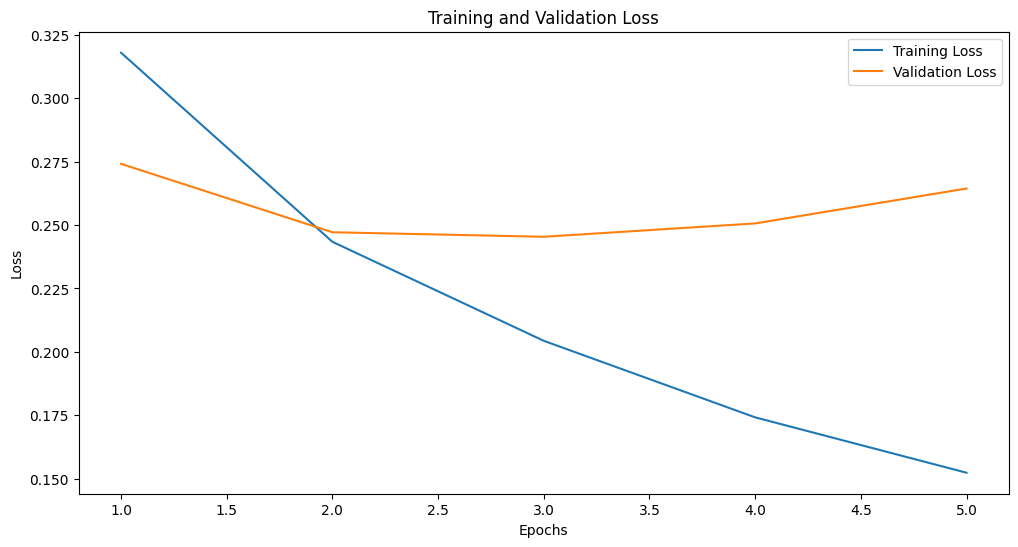

In [ ]:
# Plotting the loss curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


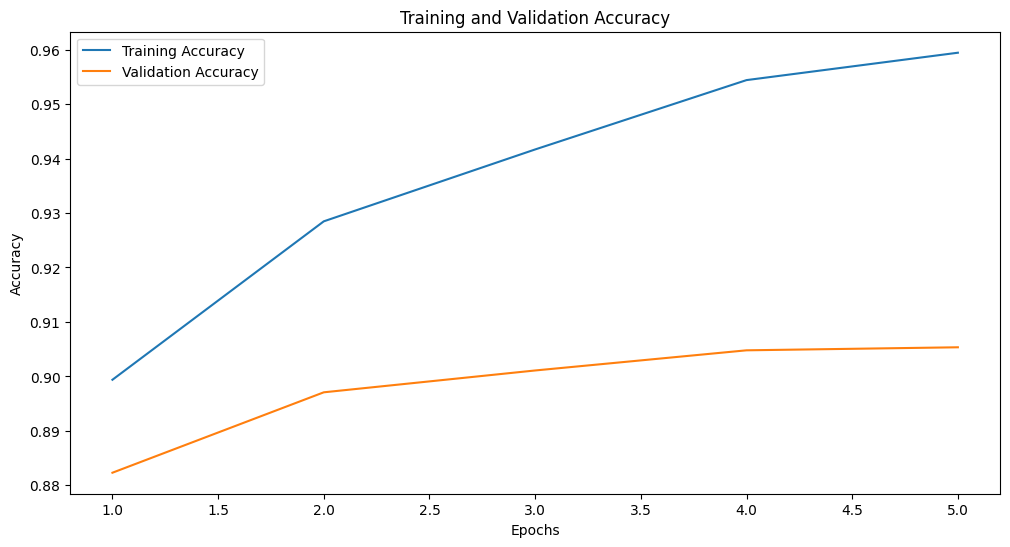

In [ ]:

# Plotting the accuracy curve
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



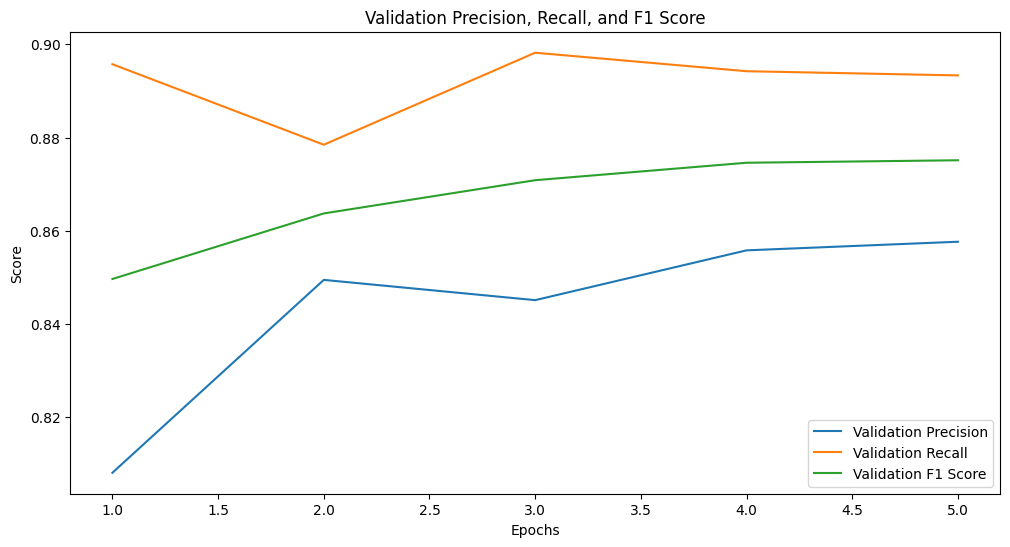

In [ ]:
# Plotting precision, recall, and F1 score curves
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_precisions, label='Validation Precision')
plt.plot(epochs_range, val_recalls, label='Validation Recall')
plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Precision, Recall, and F1 Score')
plt.legend()
plt.show()


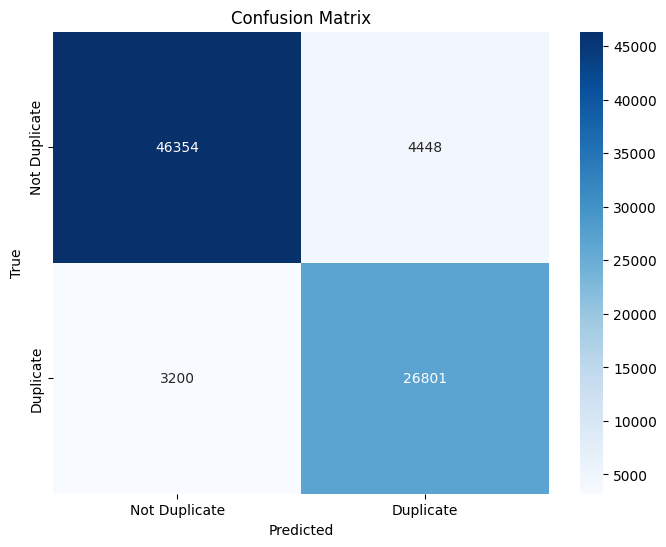

In [ ]:

# Plotting confusion matrix
val_preds = np.array(val_preds)
val_true = np.array(val_true)
cm = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Duplicate', 'Duplicate'], yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


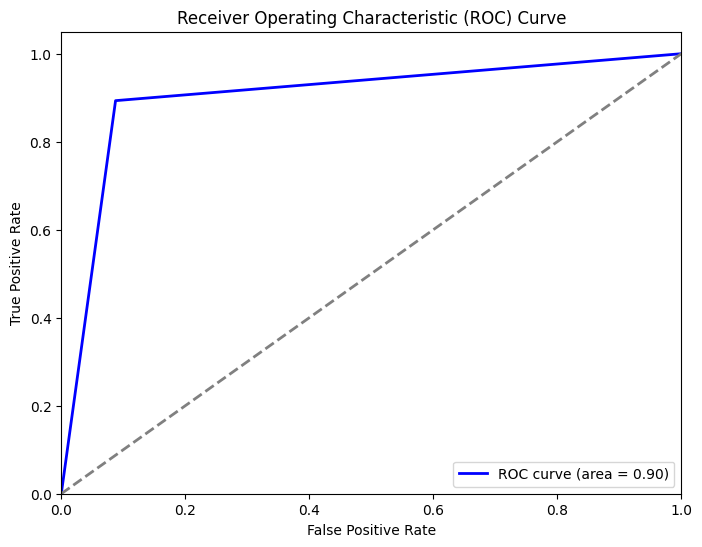

In [ ]:

# Calculating ROC curve
fpr, tpr, _ = roc_curve(val_true, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



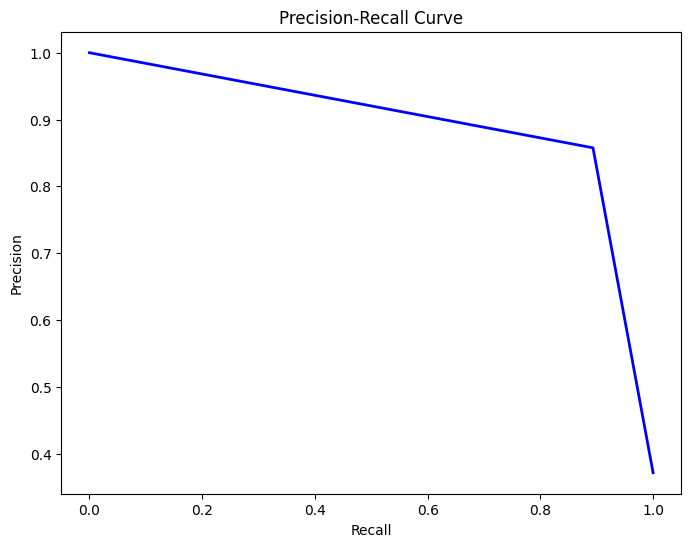

In [ ]:
# Calculating precision-recall curve
precision, recall, _ = precision_recall_curve(val_true, val_preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


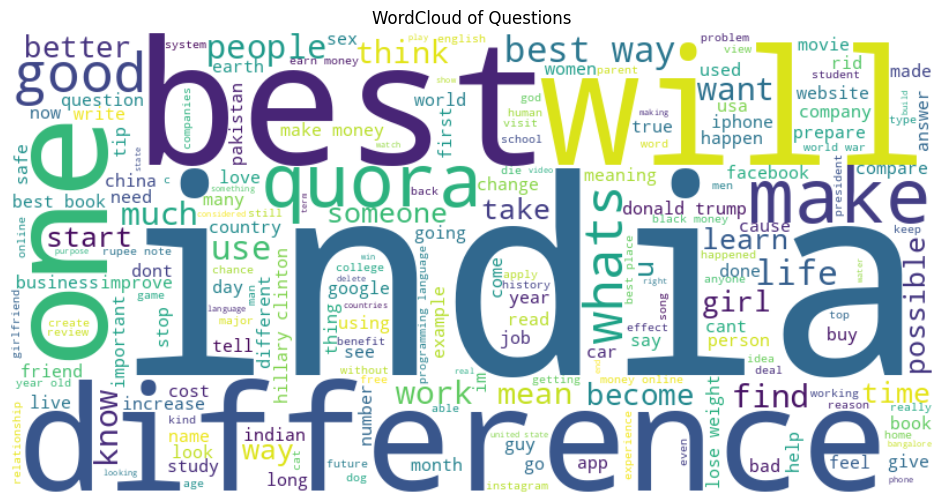

In [ ]:

# Generating a WordCloud of the most frequent words in the validation set
text = ' '.join([text for text in df['question1']] + [text for text in df['question2']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Questions')
plt.show()



/tmp/ipykernel_122/2845240141.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_losses, label='Training Loss', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_122/2845240141.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(val_losses, label='Validation Loss', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

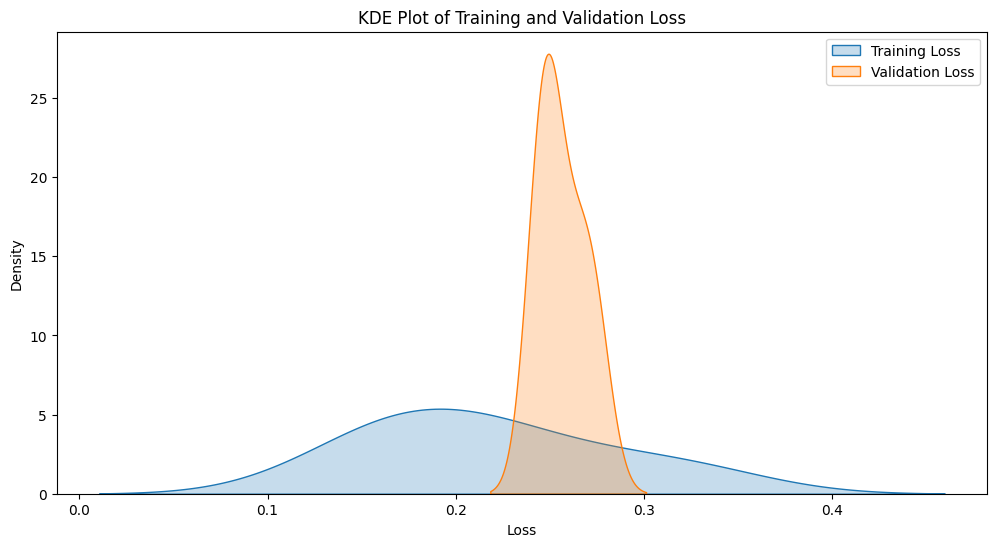

In [ ]:
# KDE Plot of the validation loss and training loss
plt.figure(figsize=(12, 6))
sns.kdeplot(train_losses, label='Training Loss', shade=True)
sns.kdeplot(val_losses, label='Validation Loss', shade=True)
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('KDE Plot of Training and Validation Loss')
plt.legend()
plt.show()



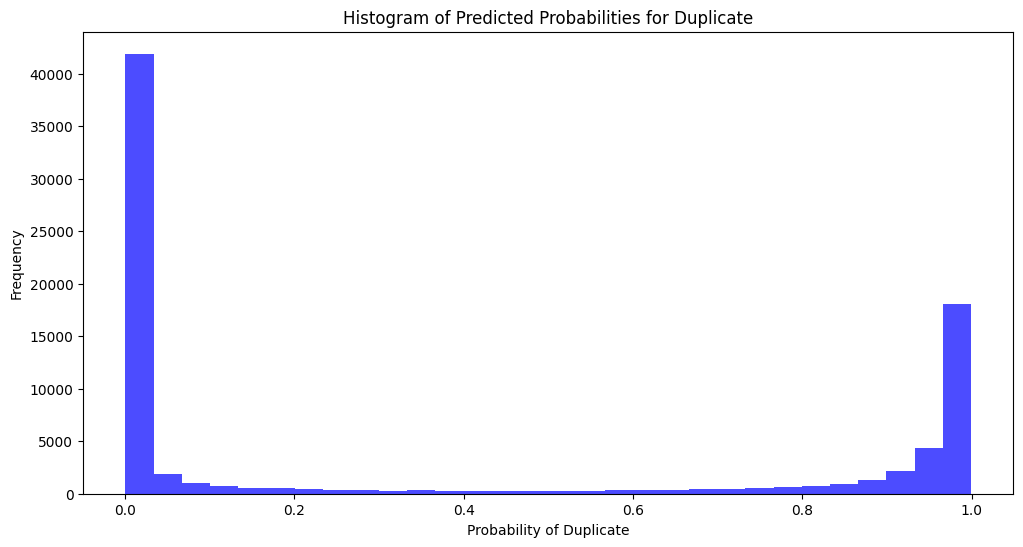

In [ ]:
# Histogram of the predicted probabilities
val_probs = []
for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Apply softmax to the logits for each class
        val_probs.extend(probs[:, 1].cpu().tolist())  # Collect probabilities for the positive class (class 1)

plt.figure(figsize=(12, 6))
plt.hist(val_probs, bins=30, color='blue', alpha=0.7)
plt.xlabel('Probability of Duplicate')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities for Duplicate')
plt.show()
